# MBTI Project - Predicting (step 6)
<br>

<div class="span5 alert alert-info">
<h3>Introduction</h3>
    <p>This notebook contains the <b>Predicting</b> step which comes after the <b>Modeling</b> step. The main goal of this step is to take completely unseen data and try to classify it using the models we trained in the previous notebook.<p>
</div>

<a id=top><a>

### Table of Contents

- [Summarized goals](#goals)
- [Importing Libraries](#importing)
- [Data Wrangling](#wrangling)
- [Predicting on Twitter Data](#predicting)
- [Looking at the results](#results)
 

<a id=goals></a>

## Summarized Goals
***

What we want to do is to classify tweets from Twitter users into the 16 MBTI types. To do this we need to:
- Find Twitter users with their MBTI in their bio
- Extract tweets from their timeline
- Use data wrangling to prepare the text data
- Implement our selected models to classify this new data
- Check if the results are accurate

Note: the python notebook called Twitter_MBTI_Scraper has the code for the first two goals.

<a id=importing></a>

## Imports
***

In [1]:
# data wrangiling libraries
import pandas as pd
import numpy as np
import feature_extraction as fe #this is a python file I made for data wrangling

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set() #

# machine learning libraries
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef
from sklearn.feature_extraction import text
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# other libraries
import os
import re
import random
import string
import pickle
import itertools
from tqdm import tqdm
tqdm.pandas(desc="Progress!")
import time
import warnings
pd.options.mode.chained_assignment = None  # default='warn'

/Users/diego/.pyenv/versions/venv-MBTI/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# these is the data we manage to extract (the scraping process using the API is a bit slow)
tweets_1 = pd.read_csv('tweets_from_users/tweets_2020_11_10.csv', index_col=0)
tweets_2 = pd.read_csv('tweets_from_users/tweets_2020_11_13.csv', index_col=0)
users_1 = pd.read_csv('twitter_users/results_2020_11_04.csv', index_col=0)
users_2 = pd.read_csv('twitter_users/results_2020_11_11.csv', index_col=None)

In [3]:
tweets = tweets_1.append(tweets_2)
users = users_1.append(users_2)

In [4]:
df = users.join(tweets, on="twitter_id")

<a id=wrangling></a>

## Data Wrangling

In [5]:
df = df[['types','tweets']]
df = df.dropna()

In [6]:
drop_these_rows = df.types.value_counts()[16:].index.to_list()

In [7]:
df = df[~df['types'].isin(drop_these_rows)]

In [8]:
df.types.value_counts()

INFP    266
INFJ    228
INTP    122
INTJ     89
ENFP     85
ENTP     68
ENFJ     32
ENTJ     31
ISFP     23
ISTP     22
ISTJ     21
ISFJ     17
ESTJ     11
ESFP     11
ESTP     10
ESFJ      6
Name: types, dtype: int64

In [9]:
fe = fe.Feature_Extraction(df)

In [10]:
df = fe.dummies_types(column='types', drop_first=True)

In [11]:
# regex remove hyperlinks
df['text_clean'] = df['tweets'].str.replace('http\S+|www.\S+', '', case=False)

In [12]:
# Removing unwanted characters
df['text_clean'] = df['text_clean'].str.replace('[^a-zA-Z]', ' ') 

In [13]:
# Making everything lowercase
df['text_clean'] = df['text_clean'].str.lower() 

In [14]:
# tokenize each post
df['text_clean'] = df['text_clean'].apply(lambda x: word_tokenize(x))

# lemmatize each word
lemmatizer = WordNetLemmatizer() 
df['text_clean'] = df['text_clean'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [15]:
df['text_clean_joined'] = df['text_clean'].apply(lambda x: " ".join(x))

In [16]:
# we will do add a remove stop words function
def remove_stop_words( x, stop_word):
        '''
        Function to remove a list of words
        @param x : (str) text 
        @param stop_word: (list) list of stopwords to delete 
        @return: (str) new string without stopwords 
        '''
        x_new = text_to_word_sequence(x)    # tokenize text 
        x_ = []
        for i in x_new:
            if i not in stop_word:
                x_.append(i)
        return " ".join(x_)

In [17]:
# MBTI types are rarely discussed in day to day converstaions, we will take them out since they would have low prediction power
types = [x.lower() for x in df['types'].unique()] 
types_plural = [x+'s' for x in types]

# some words that appear a lot but do not add value
additional_stop_words = ['ll','type','fe','ni','na','wa','ve','don','nt','nf', 'ti','se','op','ne']

# We put these together and include the normal stopwords from the English language
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words + types + types_plural)

In [18]:
df['text_clean_joined'] = df['text_clean_joined'].progress_apply(lambda x : remove_stop_words(x, stop_words))

Progress!: 100%|██████████| 1818/1818 [00:00<00:00, 2019.01it/s]


In [19]:
df['length_text'] = df['text_clean_joined'].apply(lambda x: len(x))

In [20]:
final_df = df.drop_duplicates(subset=['text_clean_joined'], keep="first")

In [21]:
df = final_df[['types','I','J','N','T','text_clean_joined','length_text']]

<a id=predicting></a>

## Predicting

In [22]:
results_df = pd.DataFrame(columns=['Model','Accuracy','ROC_AUC','MCC'])

In [23]:
# Extraversion and Introversion
loaded_vect = pickle.load(open('../4. Modeling/models/model_selection_results_EI/TF_IDF_ngram_chars_model.sav', 'rb'))
loaded_model = pickle.load(open('../4. Modeling/models/final/SGD_TFIDF_Char_Level_EI.sav', 'rb'))
target = 'I'
text = 'text_clean_joined'

y = df[target]
X = df[text]

X_transformed =  loaded_vect.transform(X) 

In [24]:
y_pred = loaded_model.predict(X_transformed)
df['prediction_IE'] = y_pred

results = {'Model': 'EI', 
     'Accuracy':accuracy_score(y,y_pred),
     'ROC_AUC':roc_auc_score(y,y_pred),
     'MCC': matthews_corrcoef(y,y_pred)}

results_df = results_df.append(results, ignore_index=True)

probabilities = loaded_model.predict_proba(X_transformed)
df['probability_E'] = [prob[0] for prob in probabilities]
df['probability_I'] = [prob[1] for prob in probabilities]

In [25]:
# Intuition & Sensing
loaded_vect = pickle.load(open('../4. Modeling/models/model_selection_results_NS/count_vect_model.sav', 'rb'))
loaded_model = pickle.load(open('../4. Modeling/models/final/SGD_Count_Vect_NS.sav', 'rb'))
target = 'N'
text = 'text_clean_joined'

y = df[target]
X = df[text]

X_transformed =  loaded_vect.transform(X) 

In [26]:
y_pred = loaded_model.predict(X_transformed)
df['prediction_NS'] = y_pred

results = {'Model': 'NS', 
     'Accuracy':accuracy_score(y,y_pred),
     'ROC_AUC':roc_auc_score(y,y_pred),
     'MCC': matthews_corrcoef(y,y_pred)}

results_df = results_df.append(results, ignore_index=True)

probabilities = loaded_model.predict_proba(X_transformed)
df['probability_S'] = [prob[0] for prob in probabilities]
df['probability_N'] = [prob[1] for prob in probabilities]

In [27]:
# Thinking and Feeling
loaded_vect = pickle.load(open('../4. Modeling/models/model_selection_results_TF/TF_IDF_model.sav', 'rb'))
loaded_model = pickle.load(open('../4. Modeling/models/model_selection_results_TF/LR_WordLevel_TF-IDF.sav', 'rb'))
target = 'T'
text = 'text_clean_joined'

y = df[target]
X = df[text]

X_transformed =  loaded_vect.transform(X) 

In [28]:
y_pred = loaded_model.predict(X_transformed)
df['prediction_TF'] = y_pred

results = {'Model': 'TF', 
     'Accuracy':accuracy_score(y,y_pred),
     'ROC_AUC':roc_auc_score(y,y_pred),
     'MCC': matthews_corrcoef(y,y_pred)}

results_df = results_df.append(results, ignore_index=True)

probabilities = loaded_model.predict_proba(X_transformed)
df['probability_F'] = [prob[0] for prob in probabilities]
df['probability_T'] = [prob[1] for prob in probabilities]

In [29]:
# Judging and Perceiving
loaded_vect = pickle.load(open('../4. Modeling/models/model_selection_results_JP/TF_IDF_model.sav', 'rb'))
loaded_model = pickle.load(open('../4. Modeling/models/model_selection_results_JP/SGD_WordLevel_TF-IDF.sav', 'rb'))
target = 'J'
text = 'text_clean_joined'

y = df[target]
X = df[text]

X_transformed =  loaded_vect.transform(X) 

In [30]:
y_pred = loaded_model.predict(X_transformed)
df['prediction_JP'] = y_pred

results = {'Model': 'JP', 
     'Accuracy':accuracy_score(y,y_pred),
     'ROC_AUC':roc_auc_score(y,y_pred),
     'MCC': matthews_corrcoef(y,y_pred)}

results_df = results_df.append(results, ignore_index=True)

probabilities = loaded_model.predict_proba(X_transformed)
df['probability_P'] = [prob[0] for prob in probabilities]
df['probability_J'] = [prob[1] for prob in probabilities]

<a id=results></a>

## Looking at the Results

In [31]:
results_df

,Model,Accuracy,ROC_AUC,MCC
0,EI,0.629808,0.544586,0.085054
1,NS,0.807692,0.527943,0.058371
2,TF,0.572115,0.590224,0.173005
3,JP,0.542308,0.528912,0.063007


In [32]:
# Create an empty list 
Row_list =[] 
  
# Iterate over each row 
for col in results_df.columns[1:]:
    Row_list.extend(results_df[col].to_list())
    
Row_list = [round(x,2) for x in Row_list]

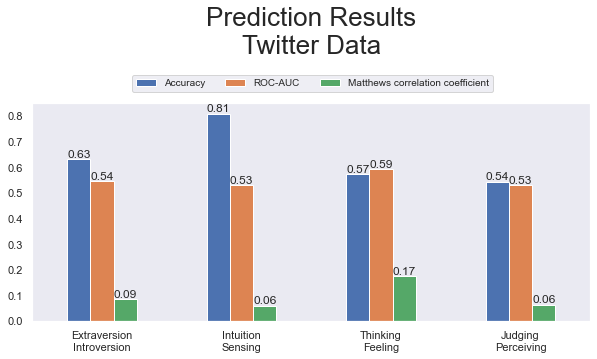

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,4))

results_df.plot(kind='bar', x='Model', ax = axes)

plt.title('Prediction Results\nTwitter Data',fontsize=26,ha='center', pad=50)
plt.xticks(ticks=[0,1,2,3],labels=['Extraversion\nIntroversion',
                                   'Intuition\nSensing',
                                   'Thinking\nFeeling',
                                   'Judging\nPerceiving'], rotation=360)
plt.xlabel('')
plt.grid(None)

rects = axes.patches

for rect, value in zip(rects, Row_list):
    height = rect.get_height()
    axes.text(rect.get_x() + rect.get_width() / 2, height, s=value, ha='center', va='bottom')

labels = ['Accuracy','ROC-AUC','Matthews correlation coefficient']
plt.legend(labels=labels, loc=3, ncol=3,  mode="", borderaxespad=.5, frameon=True, bbox_to_anchor=(0.17, 1.03, 1., 0), fontsize=10)

plt.savefig('img/Results_prediction_acc_roc_mcc.png', transparent=True, bbox_inches='tight')
plt.show()

In [34]:
checking = df[['text_clean_joined', 'I','N','T','J','probability_I','length_text','prediction_IE','prediction_NS','prediction_TF','prediction_JP']]

In [35]:
checking['corrects_IE'] = checking['I'] == checking['prediction_IE']
checking['corrects_NS'] = checking['N'] == checking['prediction_NS']
checking['corrects_TF'] = checking['T'] == checking['prediction_TF']
checking['corrects_JP'] = checking['J'] == checking['prediction_JP']

In [36]:
checking['total'] = checking.iloc[:,8:12].sum(axis=1)

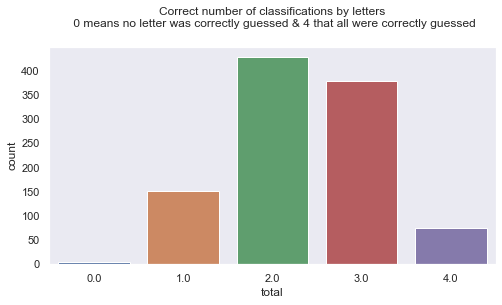

In [53]:
plt.figure(figsize=(8,4))
sns.countplot(x='total',data=checking)
plt.title('Correct number of classifications by letters\n 0 means no letter was correctly guessed & 4 that all were correctly guessed', size=12, pad=20)
plt.grid(False)
plt.savefig('img/Number_of_correct_classifications.png', transparent=True, bbox_inches='tight')
plt.show()

In [38]:
checking['length_text'] = [len(x) for x in checking['text_clean_joined']]

In [39]:
low = checking['length_text'].quantile(0.25)
medium_low = checking['length_text'].quantile(0.5)
medium_high = checking['length_text'].quantile(0.75)

In [40]:
length_bins = []
for i in checking['length_text']:
    if i < low:
        length_bins.append('low')
    elif low <= i < medium_low:
        length_bins.append('medium_low')
    elif medium_low <= i < medium_high:
        length_bins.append('medium_hight')
    else:
        length_bins.append('high')

In [41]:
checking['length_bins'] =length_bins

In [42]:
checking

,text_clean_joined,I,N,T,J,probability_I,length_text,prediction_IE,prediction_NS,prediction_TF,prediction_JP,corrects_IE,corrects_NS,corrects_TF,corrects_JP,total,length_bins
0,meganmmalone thought current voting u,1,1,0,0,1.000000,37,1,1,1,0,True,True,False,True,3.0,low
0,hahahahahahahahahahah eng sherep eng sherep sh...,1,1,0,0,0.771063,4071,1,0,1,0,True,False,False,True,2.0,medium_hight
1,nwestnomad agree person terrify country terrif...,1,1,0,1,0.854206,5995,1,1,0,1,True,True,True,True,3.0,high
2,alli s major ordeal sure thing looking biden p...,1,1,1,1,0.716798,5152,1,1,0,1,True,True,False,True,3.0,high
2,hi lt haven t talked ur pfp cute d love know f...,1,1,1,1,0.322657,4368,0,1,0,0,False,True,False,False,1.0,medium_hight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,michellemalkin greenskydeb maga lost joe biden...,1,1,0,1,0.461513,5266,0,1,1,1,False,True,False,True,3.0,high
683,hate diet culture making afraid carbs m happy ...,0,1,0,0,0.489097,5377,0,1,0,0,True,True,True,True,2.0,high
684,reason gay men calling girl bitch pas like gir...,0,1,0,0,0.621041,3645,1,1,0,0,False,True,True,True,1.0,medium_low
685,violetaml thank lola yes wish flesh parental o...,1,1,0,1,0.596425,4723,1,1,0,1,True,True,True,True,3.0,high


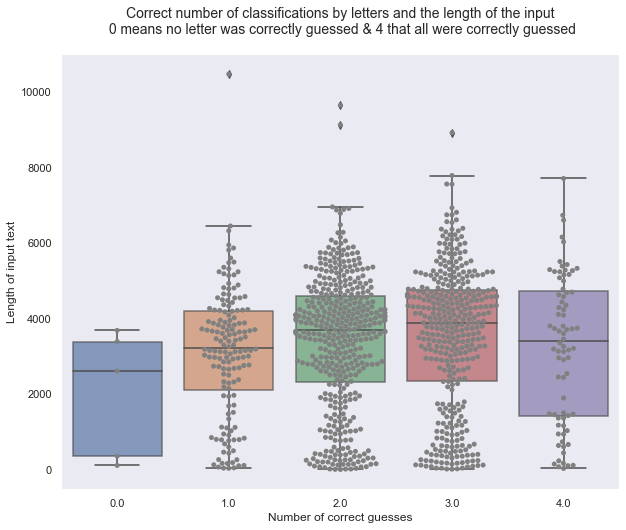

In [55]:
plt.figure(figsize=(10,8))

sns.boxplot(x='total', y='length_text', data=checking, boxprops=dict(alpha=0.7))
sns.swarmplot(x='total', y='length_text', data=checking, color='gray')
plt.title('Correct number of classifications by letters and the length of the input\n 0 means no letter was correctly guessed & 4 that all were correctly guessed', size=14, pad=20)
plt.xlabel('Number of correct guesses')
plt.ylabel('Length of input text')
plt.grid(False)

plt.savefig('img/length_tweet_corpus_vs_correct_guesses.png', transparent=True, bbox_inches='tight')

plt.show()

(-0.19164104746080723, 4.6452552748720934e-10)


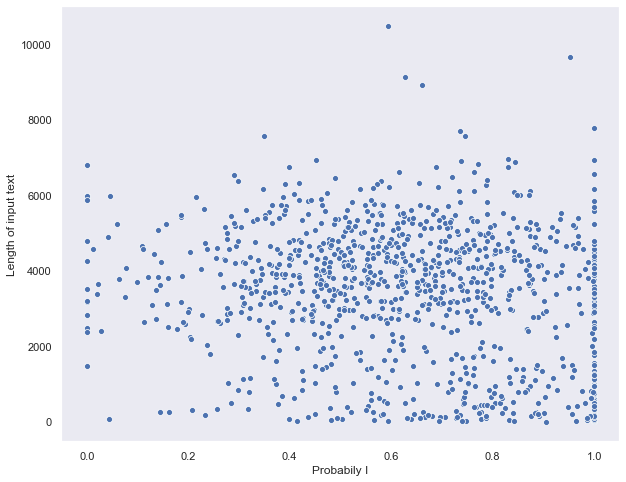

In [114]:
from scipy import stats

plt.figure(figsize=(10,8))

print(stats.pearsonr(x=checking['probability_I'], y=checking['length_text']))
sns.scatterplot(x='probability_I', y='length_text', data=checking)
plt.xlabel('Probabily I')
plt.ylabel('Length of input text')
plt.grid(False)
plt.show()

In [127]:
comprobar = df[df['T'] != df['prediction_TF']][['probability_T','probability_F']]

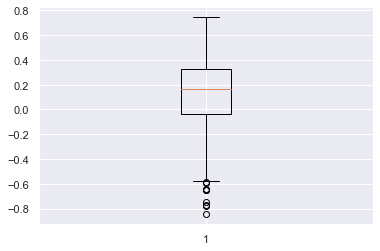

In [152]:
x = comprobar['probability_T'] - comprobar['probability_F']

plt.boxplot(x=x)

plt.show()